In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
from sqlalchemy import create_engine, MetaData
from sqlalchemy.ext.automap import automap_base

# Reflect the existing database
metadata = MetaData(bind=engine)
metadata.reflect()

# Create a base for the new model and reflect tables
Base = automap_base(metadata=metadata)
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
for table_name, table_class in Base.classes.items():
    print(table_name)

measurement
station


In [7]:
# Save references to each table
table_references = {}

measurement_class = Base.classes.measurement
station_class = Base.classes.station

table_references['hawaii_measurement'] = measurement_class
table_references['hawaii_station'] = station_class


In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
from sqlalchemy import func

most_recent_date = session.query(measurement_class.date).order_by(measurement_class.date.desc()).first()

most_recent_date = most_recent_date[0]
most_recent_date = dt.date.fromisoformat(most_recent_date)
year_ago = most_recent_date - dt.timedelta(days= 365)

year_ago
# Go one year back from the most recent date


datetime.date(2016, 8, 23)

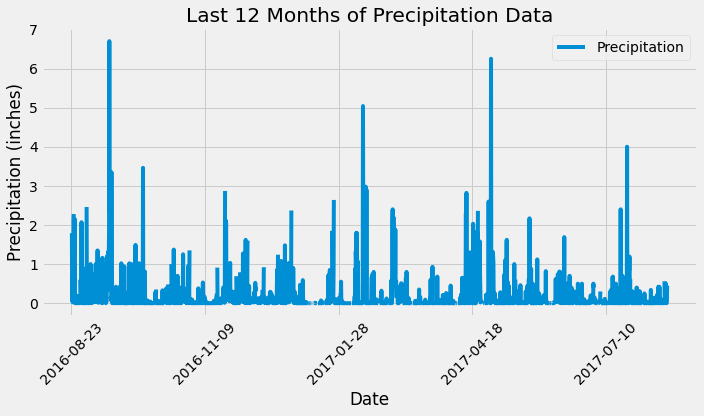

In [15]:

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement_class.date, measurement_class.prcp).filter(measurement_class.date >= year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate summary statistics
summary_stats = df['Precipitation'].describe()

# Print the summary statistics
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset

# Perform a query to calculate the total number of stations
total_stations = session.query(func.count(station_class.station)).scalar()

# Print the total number of stations
print("Total number of stations:", total_stations)

Total number of stations: 9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(measurement_class.station, func.count(measurement_class.station)).\
    group_by(measurement_class.station).\
    order_by(func.count(measurement_class.station).desc()).all()

#List the stations and their counts in descending order.
print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement_class.tobs), func.max(measurement_class.tobs), func.avg(measurement_class.tobs)).\
    filter(measurement_class.station == most_active_station).all()

# Extract the temperature statistics
lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
average_temp = temperature_stats[0][2]

# Print the temperature statistics
print(f"Temperature Statistics for the Most Active Station (Station ID: {most_active_station}):")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {average_temp}°F")

Temperature Statistics for the Most Active Station (Station ID: USC00519281):
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66378066378067°F


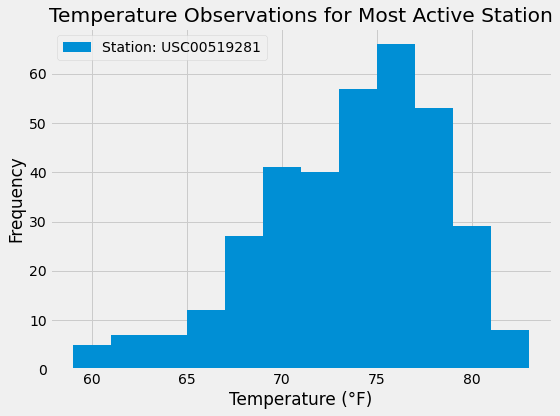

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(measurement_class.date, measurement_class.tobs).\
    filter(measurement_class.station == most_active_station).\
    filter(measurement_class.date >= year_ago).all()

# Get the temperature observations
temperatures = [result[1] for result in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for Most Active Station')
plt.legend([f'Station: {most_active_station}'])
plt.tight_layout()
plt.show()


# Close Session

In [53]:
# Close Session
session.close()